classification of dogs and cats images using pretrained VGG16 model

In [22]:
import numpy as np
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [24]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['dog','cat'],batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['dog','cat'],batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['dog','cat'],batch_size=10)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [25]:
train_batches[0][0].shape

(10, 224, 224, 3)

In [61]:
test_batches.class_indices

{'dog': 0, 'cat': 1}

In [72]:
def plot(ims, figsize=(12,6),rows=1,interp=False,titles = None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1]!=3:
            ims = ims.transpose((0,2,3,1))
    f=plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2==0 else len(ims)//rows+1
    for  i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],interpolation=None if interp else 'none')

<h3>Architecture for VGG16</h3>

In [41]:
def VGG_16(weights_path=None):
    model = Sequential([
        Conv2D(64,(3,3),input_shape =(224, 224, 3),activation='relu',padding='same',name='block1_conv1'),
        Conv2D(64,(3,3),activation='relu',padding='same',name='block1_conv2'),
        MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block1_pool'),
        
        Conv2D(128,(3,3),activation='relu',padding='same',name='block2_conv1'),
        Conv2D(128,(3,3),activation='relu',padding='same',name='block2_conv2'),
        MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block2_pool'),
        
        Conv2D(256,(3,3),activation='relu',padding='same',name='block3_conv1'),
        Conv2D(256,(3,3),activation='relu',padding='same',name='block3_conv2'),
        Conv2D(256,(3,3),activation='relu',padding='same',name='block3_conv3'),
        MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block3_pool'),
        
        Conv2D(512,(3,3),activation='relu',padding='same',name='block4_conv1'),
        Conv2D(512,(3,3),activation='relu',padding='same',name='block4_conv2'),
        Conv2D(512,(3,3),activation='relu',padding='same',name='block4_conv3'),
        MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block4_pool'),
        
        Conv2D(512,(3,3),activation='relu',padding='same',name='block5_conv1'),
        Conv2D(512,(3,3),activation='relu',padding='same',name='block5_conv2'),
        Conv2D(512,(3,3),activation='relu',padding='same',name='block5_conv3'),
        MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block5_pool'),
        
        Flatten(name='flatten'),
        Dense(4096,activation='relu',name='fc1'),
        Dense(4096,activation='relu',name='fc2'),
        Dense(2,activation='softmax',name='predictions')
    ])
    
    if weights_path:
        model.load_weights(weights_path)
        print('weight added')

    return model

In [42]:
vgg16_model  = VGG_16('vgg16_weights_kernels.h5')

weight added


In [43]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [44]:
vgg16_model.pop()

In [45]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [46]:
for layer in vgg16_model.layers:
    layer.trainable=False

In [47]:
vgg16_model.add(Dense(2,activation='softmax',name='pred'))

In [48]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [49]:
vgg16_model.compile(Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
vgg16_model.fit_generator(train_batches,steps_per_epoch=4,validation_data=valid_batches,validation_steps=4,epochs=10,verbose=2)

Epoch 1/10
 - 49s - loss: 0.3789 - acc: 0.8000 - val_loss: 0.8710 - val_acc: 0.5625
Epoch 2/10
 - 48s - loss: 0.3181 - acc: 0.8500 - val_loss: 0.8351 - val_acc: 0.5625
Epoch 3/10
 - 46s - loss: 0.2709 - acc: 0.9000 - val_loss: 0.8046 - val_acc: 0.5625
Epoch 4/10
 - 45s - loss: 0.2360 - acc: 0.9500 - val_loss: 0.7784 - val_acc: 0.5625
Epoch 5/10
 - 46s - loss: 0.2067 - acc: 0.9500 - val_loss: 0.7562 - val_acc: 0.5625
Epoch 6/10
 - 46s - loss: 0.1805 - acc: 0.9500 - val_loss: 0.7363 - val_acc: 0.6250
Epoch 7/10
 - 48s - loss: 0.1606 - acc: 0.9500 - val_loss: 0.7187 - val_acc: 0.6250
Epoch 8/10
 - 46s - loss: 0.1431 - acc: 0.9750 - val_loss: 0.7022 - val_acc: 0.6250
Epoch 9/10
 - 45s - loss: 0.1294 - acc: 0.9750 - val_loss: 0.6895 - val_acc: 0.6250
Epoch 10/10
 - 46s - loss: 0.1164 - acc: 1.0000 - val_loss: 0.6759 - val_acc: 0.6250


In [52]:
test_imgs,test_labels = next(test_batches)

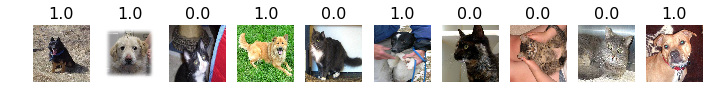

In [66]:
plot(test_imgs,titles=test_labels)

In [53]:
test_labels = test_labels[:,0]

In [62]:
test_labels

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [54]:
predictions = vgg16_model.predict_generator(test_batches,steps=1,verbose=0)

In [55]:
predictions

array([[0.9927113 , 0.00728868],
       [0.03322625, 0.96677375],
       [0.36686733, 0.63313264],
       [0.11259574, 0.88740426],
       [0.17361195, 0.82638806],
       [0.85833454, 0.14166544],
       [0.01177031, 0.9882297 ],
       [0.10172163, 0.89827836],
       [0.00189053, 0.99810946],
       [0.99790716, 0.00209287]], dtype=float32)

In [67]:
np.round(predictions[:,0])

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [56]:
cm = confusion_matrix(test_labels,np.round(predictions[:,0]))

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [70]:
cm_plot_labels = ['cat','dog']

Confusion matrix, without normalization
[[5 0]
 [2 3]]


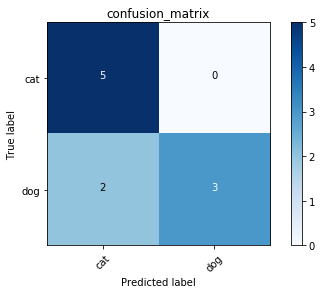

In [71]:
plot_confusion_matrix(cm,cm_plot_labels,title='confusion_matrix')